In [2]:
# Importing libraries
import os
import sys
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import imread
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [ ]:
# Downloading model
!wget http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat

In [ ]:
# Preparing pre-trained model
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("/content/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor: shape=(1, 150, 200, 64), dtype=float32, numpy=
array([[[[0.3017251 , 0.28211457, 2.4223394 , ..., 1.0978041 ,
          0.6943142 , 1.1990578 ],
         [0.4236383 , 0.56422913, 2.929648  , ..., 1.4904113 ,
          0.85025394, 1.3337202 ],
         [0.4236383 , 0.56422913, 2.929648  , ..., 1.4904113 ,
          0.85025394, 1.3337202 ],
         ...,
         [0.4236383 , 0.56422913, 2.929648  , ..., 1.4904113 ,
          0.85025394, 1.3337202 ],
         [0.4236383 , 0.56422913, 2.929648  , ..., 1.4904113 ,
          0.85025394, 1.3337202 ],
         [0.45847648, 0.7558249 , 2.4548836 , ..., 1.3755586 ,
          0.8204465 , 0.85222447]],

        [[0.5808615 , 0.56422913, 2.9793456 , ..., 1.630708  ,
          0.7594994 , 0.69129264],
         [0.8020993 , 1.1284583 , 3.6142726 , ..., 2.1600845 ,
          0.9419426 , 0.71724135],
         [0.8020993 , 1.1284583 , 3.6142726 , ..., 2.1600845 ,
          0.9419426 , 0.71724135],
         ...,
         [0.8

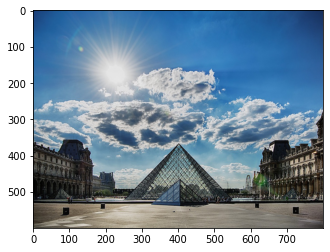

In [ ]:
content_image = imread("/images/louvre.jpg")
imshow(content_image);

In [ ]:
def compute_content_cost(a_C,a_G):
    #Retrieve dimensions from a_G
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    #Unrolled a_C and a_G
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    
    #Compute the Content Cost
    j_content = (1/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))))

    return j_content

In [ ]:
def compute_style_cost_layer(a_S,a_G):
    #Retrieve dimensions from a_G
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    #unroll a_S and a_G
    a_S = tf.transpose(tf.reshape(a_S,shape=[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape=[n_H*n_W,n_C]))
    
    #Computing gram matrics
    S = tf.matmul(a_S,tf.transpose(a_S))
    G = tf.matmul(a_G,tf.transpose(a_G))
    
    #Compute the Style Cost
    j_style_layer = (1/(4*(n_C**2)*((n_H*n_W)**2)))*(tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(S,G)))))
    
    return j_style_layer

In [ ]:
style_layers = [('conv1_2',0.3),
               ('conv3_2',0.3),
               ('conv3_3',0.3),
               ('conv4_2',0.3),
               ('conv5_1',0.3)]

In [ ]:
def compute_style_cost(model, style_layers):
    
    #initialize overall cost
    j_style=0
    
    for layer_name,coeff in style_layers:
        #select the output tensor of the currently selected layer
        out = model[layer_name]
        
        #set a_S to be the activaltion of the currently selected layer by running the session on out
        a_S = sess.run(out)
        
        #set a_G to be the activaltion from the same layer
        a_G = model[layer_name]
        
        #compute style cost for the current layer
        j_style_layer = compute_style_cost_layer(a_S,a_G)
        
        #Add coeff to j_style layer to compute the cost from overall layers
        j_style += coeff*j_style_layer
        
    return j_style

In [ ]:
def total_cost(j_content, j_style, alpha=10, beta=40):
    
    j = (alpha*j_content) + (beta*j_style)
    
    return j 

In [ ]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()

In [ ]:
content_image = imread("louvre_small.jpg")
content_image = reshape_and_normalize_image(content_image)

In [ ]:
style_image = imread("monet.jpg")
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


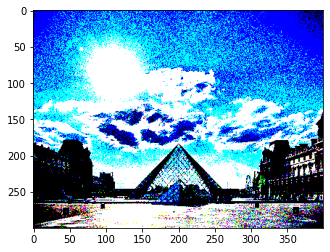

In [ ]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [ ]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [ ]:
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
j_content = compute_content_cost(a_C, a_G)

In [ ]:
sess.run(model['input'].assign(style_image))
j_style = compute_style_cost(model, style_layers)

In [ ]:
j = total_cost(j_content,j_style,alpha=10,beta=40)

In [ ]:
#OPTIMIZER
#Using Adam Optimizer to minimize the cost
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.3)
train_set = optimizer.minimize(j)

In [ ]:
def save_image(path, image):  
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imsave(path, image)

In [ ]:
def model_nn(sess, input_image, num_iterations = 150):
    sess.run(tf.compat.v1.global_variables_initializer())
    # Run the noisy input image
    generated_image = sess.run(model["input"].assign(input_image))
    for i in range(num_iterations):
        # Run the session on the train_step to minimize the total cost
        sess.run(train_set)
        generated_image = sess.run(model["input"])
        # Print every 20 iteration.
        if i%20 == 0:
            J, Jc, Js = sess.run([j, j_content, j_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(J))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            save_image("" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess,generated_image)

Iteration 0 :
total cost = 8169100300.0
content cost = 7570.7866
style cost = 204225620.0
Iteration 20 :
total cost = 5260286500.0
content cost = 9020.166
style cost = 131504904.0
Iteration 40 :
total cost = 3584087000.0
content cost = 10705.161
style cost = 89599500.0
Iteration 60 :
total cost = 2861358300.0
content cost = 11843.45
style cost = 71530990.0
Iteration 80 :
total cost = 2496281900.0
content cost = 12645.201
style cost = 62403884.0
Iteration 100 :
total cost = 2249592000.0
content cost = 13243.667
style cost = 56236492.0
Iteration 120 :
total cost = 2062940500.0
content cost = 13748.635
style cost = 51570076.0
Iteration 140 :
total cost = 1910962400.0
content cost = 14189.097
style cost = 47770510.0


array([[[[-24.330145  ,  -7.412203  ,  36.094017  ],
         [-31.228823  , -10.475587  ,  36.807396  ],
         [-21.606453  ,   6.4406347 ,  20.593882  ],
         ...,
         [-13.863778  , -15.607587  ,  18.882576  ],
         [-27.113781  ,  -4.944581  ,  34.239594  ],
         [ -7.7342725 ,   2.628315  ,  32.087673  ]],

        [[-21.362226  ,   2.0346985 ,  29.799746  ],
         [-74.81757   , -41.724594  ,  32.366047  ],
         [-63.694473  , -42.10624   ,   9.947617  ],
         ...,
         [-38.060535  , -28.447372  ,  10.671273  ],
         [-60.92493   , -54.987614  ,  12.85662   ],
         [-11.941522  ,  -9.16916   ,  34.431656  ]],

        [[-76.07398   , -36.110893  ,  26.520306  ],
         [-66.2953    , -34.53612   ,  -0.89761007],
         [-59.044563  , -32.56461   ,  48.15408   ],
         ...,
         [-25.569565  , -30.982048  ,  14.589437  ],
         [-55.36915   , -51.653656  ,  22.918932  ],
         [-65.16329   , -60.23925   ,  21.220018  ]],

In [ ]:
# Supported Version for this 

# import imageio
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
# from matplotlib.pyplot import imread
# from PIL import Image
# from nst_utils import *
# import numpy as np
# import tensorflow as tf
# import pprint
import matplotlib,PIL
print("Image.io ->", imageio.__version__)
print("matplotlib ->", matplotlib.__version__)
print("Pillow ->", PIL.__version__)
print("numpy ->",np.__version__)
print("tensorflow ->",tf.__version__)

Image.io -> 2.4.1
matplotlib -> 3.2.2
Pillow -> 7.1.2
numpy -> 1.19.5
tensorflow -> 2.4.1


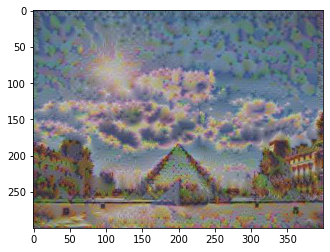

In [ ]:
result=imread("generated_image.jpg")
imshow(result)